In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

import torch
import torch.nn as nn

In [2]:
%%time
df = pd.read_excel('./indeed_results_pp_2020-04-25.xlsx')

Wall time: 14.6 s


In [3]:
new_df = df[(df['Title_New'].notnull()) & (df['Salary_Average'] != 0)][['Time', 'Title_New', 'Salary_Average', 'Salary_Unit_Day', 'Salary_Unit_Hour', 'Salary_Unit_Month', 'Salary_Unit_Week', 'Salary_Unit_Year']].sort_values(by='Time').reset_index().drop(['index'], axis=1)

In [4]:
new_df['Time'] = new_df['Time'].apply(lambda x: np.datetime64(f'{x}'))

In [5]:
new_df

,Time,Title_New,Salary_Average,Salary_Unit_Day,Salary_Unit_Hour,Salary_Unit_Month,Salary_Unit_Week,Salary_Unit_Year
0,2019-10-24,graphic designer,16000,0,0,1,0,0
1,2019-10-24,graphic designer,16000,0,0,1,0,0
2,2019-10-24,graphic designer,32500,0,0,1,0,0
3,2019-10-26,graphic designer,14000,0,0,1,0,0
4,2019-10-27,front end developer,20000,0,0,1,0,0
...,...,...,...,...,...,...,...,...
1332,2020-04-24,web developer,350000,0,0,0,0,1
1333,2020-04-24,machine learning developer,550000,0,0,0,0,1
1334,2020-04-24,front end developer,1100000,0,0,0,0,1
1335,2020-04-24,back end developer,32500,0,0,1,0,0


In [6]:
new_df.dtypes

Time                 datetime64[ns]
Title_New                    object
Salary_Average                int64
Salary_Unit_Day               int64
Salary_Unit_Hour              int64
Salary_Unit_Month             int64
Salary_Unit_Week              int64
Salary_Unit_Year              int64
dtype: object

In [7]:
y = new_df[(new_df['Title_New'] == 'graphic designer') & (new_df['Salary_Unit_Month'] == 1)][['Time', 'Title_New', 'Salary_Average']].groupby(by='Time').mean()

In [8]:
y.head()

,Salary_Average
Time,
2019-10-24,21500.000000
2019-10-26,14000.000000
2019-10-27,18000.000000
2019-10-30,22500.000000
2019-11-02,18166.666667


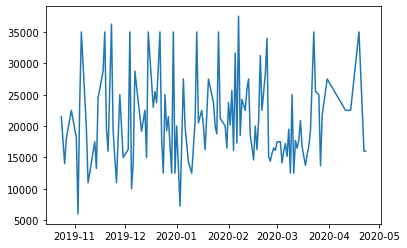

In [9]:
plt.plot(y.index, y['Salary_Average'])

In [10]:
test_size = 10
train_set = y[:-test_size].values
test_set = y[-test_size:]

In [66]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1).cuda()
window_size = 5

def input_data(seq, ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    
    return out

train_data = input_data(train_norm, window_size)

In [67]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
        self.hidden = (
            torch.zeros(1, 1, hidden_size),
            torch.zeros(1, 1, hidden_size)
        )
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1), self.hidden
        )
        pred = self.linear(lstm_out.view(len(seq), -1))
        
        return pred[-1]

In [113]:
torch.manual_seed(101)

model = LSTMnetwork().cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
%%time
epochs = 5000

for i in range(epochs):
    
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                       torch.zeros(1, 1, model.hidden_size).cuda())
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    if (i+1) % 500 == 0:
        print(f'Epoch {i+1} Loss {loss.item()}')

Epoch 100 Loss 0.05199907347559929
Epoch 200 Loss 0.009275461547076702
Epoch 300 Loss 0.012172468937933445
Epoch 400 Loss 0.0026181209832429886
Epoch 500 Loss 0.07705321907997131
Epoch 600 Loss 0.00030459367553703487
Epoch 700 Loss 0.0018465094035491347
Epoch 800 Loss 0.013883587904274464
Epoch 900 Loss 0.00047364295460283756
Epoch 1000 Loss 0.012982184067368507
Epoch 1100 Loss 2.7231576495978516e-06
Epoch 1200 Loss 0.00557090574875474
Epoch 1300 Loss 0.0038527455180883408
Epoch 1400 Loss 0.0034704001154750586
Epoch 1500 Loss 6.025981747370679e-06
Epoch 1600 Loss 8.152743248501793e-06
Epoch 1700 Loss 0.0003406012838240713
Epoch 1800 Loss 2.231487087556161e-05
Epoch 1900 Loss 9.825488632486667e-06
Epoch 2000 Loss 1.3400351235759445e-05
Epoch 2100 Loss 0.0005838776123709977
Epoch 2200 Loss 7.152597731874266e-07
Epoch 2300 Loss 5.936477975865273e-08
Epoch 2400 Loss 0.0008397023193538189
Epoch 2500 Loss 0.0003295345522928983
Epoch 2600 Loss 0.00032740968163125217
Epoch 2700 Loss 0.00017328

In [ ]:
%%time
future = 10

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).cuda()
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_size).cuda(),
                       torch.zeros(1, 1, model.hidden_size).cuda())
        
        preds.append(model(seq).item())

In [ ]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))

In [ ]:
plt.plot(test_set.index, test_set.values)
plt.plot(test_set.index, true_predictions)

In [ ]:
100 - sqrt(mean_squared_error(test_set.values.reshape(-1), true_predictions)) / test_set * 100

In [ ]:
sqrt(mean_squared_error(test_set.values.reshape(-1), true_predictions))

In [ ]:
(1 - sqrt(mean_squared_error(test_set.values.reshape(-1), true_predictions)) / test_set).mean() * 100